# Data Inventory & Basic Profiling (update this)
Here we gather basic information on the dataset such as types of sensor data, data formats, collection statistics, integrity checks. The goal is to gain understand the data at a deeper level before performing data cleaning, data manipulation, or modeling. This notebook will be structured as follows:

1. **Data Sources Overview** [Chris]
    - List all available sensor types (e.g., power, temperature, pressure etc.).
    - Identify sampling rates, units, and synchronization timestamps.
    - Look into “lens contamination” labeling (e.g., manual inspection? threshold-based? maintenance logs?).
    - Check metadata: machine ID, job ID, material type, cutting parameters, etc.
    - visualization

2. **Data Format & Structure** [Gao]
    - File formats: CSV, binary logs, SQL tables, etc.
    - Hierarchical structure: per run, per machine, per job.
    - Time column availability and time zone consistency.
    - Missing values, inconsistent timestamps, and data dropouts.

3. **Collection Statistics (Descriptive Analytics)** [Wu]
    
    For each sensor:
    
    - Count, mean, std dev, min, max, median, IQR.
    - Missing value ratio (% of NaN).
    - Data frequency: average samples per second.
    - Outlier ratio (e.g., z-score > 3 or IQR-based).

4. **Data Integrity Checks** [Gao]
    - Sudden jumps in signal due to resets or sensor errors.
    - Alignment across sensors (are they synchronized?).
    - Duplicate timestamps or inconsistent sampling.






# 0. Load CSV and Labels

In [1]:
# @title 0.0 Mount Drive and convert data (as needed)

import sys
import os
import time
from google.colab import drive
import pandas as pd

# Define paths
DRIVE_PATH = '/content/gdrive'

ADIGE_PATH = os.path.join(DRIVE_PATH, 'MyDrive/Team 1 - Adige BLM/') # !NOTE: Create a shortcut of the shared-folder in your drive
BIN_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database')
CSV_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database_CSV')
CODING_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'coding')

# Mount GDrive
try:
    # Set force_remount=True for reliability in Colab
    drive.mount(DRIVE_PATH, force_remount=True)
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    sys.exit(1)

# Wait briefly for mount
time.sleep(5)

# Check if the project directory exists
if os.path.exists(ADIGE_PATH):
    print(f"Project directory accessible at {ADIGE_PATH}\n")
else:
    print(f"Error: The project directory was not found at {ADIGE_PATH}")
    sys.exit(1)

# Check if CSV file doesn't exist, if so convert with bin2csv
sys.path.append(CODING_PATH)
try:
    from bin_parser import bin_parser
except ImportError:
    print(f"Error: bin_parser.py not found in {CODING_PATH}")
    sys.exit(1)

# Get sorted list of BIN machine folders from database folder
try:
    machine_folders = sorted([d for d in os.listdir(BIN_PATH) if os.path.isdir(os.path.join(BIN_PATH, d))])
except FileNotFoundError:
    print(f"Error: Binary database directory not found at {BIN_PATH}")
    sys.exit(1)


# Check for existing CSVs and determine which machines need processing
machines_to_process = []
for machine_folder in machine_folders:
    csv_file_path = os.path.join(CSV_PATH, f"{machine_folder}.csv")
    if not os.path.exists(csv_file_path):
        machines_to_process.append(machine_folder)
        print(f"CSV for {machine_folder} not found. Adding to processing queue.")
    #else:
    #    print(f"CSV for {machine_folder} already exists. Skipping.")

# Convert if there are still machines without CSV version
if machines_to_process:
    print(f"\nProcessing {len(machines_to_process)} machines:")
    for machine_name in machines_to_process:

      """
      Processes all .bin files of one machine → outputs one global CSV.
      """

      machine_path = os.path.join(BIN_PATH, machine_name)
      bin_files = sorted([f for f in os.listdir(machine_path) if f.endswith(".bin")])

      all_dfs = []
      for bf in bin_files:
          try:
              [name, data] = bin_parser(os.path.join(machine_path, bf))
              df = pd.DataFrame(data, columns=name)
              if not df.empty:
                  all_dfs.append(df)
          except Exception as e:
              print(f"Error reading {bf}: {e}")

      big_df = pd.concat(all_dfs, ignore_index=True)
      out_csv = os.path.join(CSV_PATH, f"{machine_name}.csv")
      big_df.to_csv(out_csv, index=False)
      print(f'{out_csv} file generated.')
else:
    print("\nAll machine CSVs already exist. No conversion needed.")

Mounted at /content/gdrive
Project directory accessible at /content/gdrive/MyDrive/Team 1 - Adige BLM/


All machine CSVs already exist. No conversion needed.


In [2]:
# @title 0.1 Create labels folder & Copy .log files into it
import shutil

LABEL_PATH = os.path.join(DRIVE_PATH, ADIGE_PATH, 'database_labels')

# if there is no labels path, create it
if not os.path.exists(LABEL_PATH):
    os.makedirs(LABEL_PATH)

# Get sorted list of BIN machine folders from database folder
try:
    machine_folders = sorted([d for d in os.listdir(BIN_PATH) if os.path.isdir(os.path.join(BIN_PATH, d))])
except FileNotFoundError:
    print(f"Error: Binary database directory not found at {BIN_PATH}")
    sys.exit(1)

#for machine_folder in filter(os.path.isdir, os.listdir(os.getcwd())):
for machine_folder in machine_folders:
    # skip none directories inside BIN_PATH
    machine_path = os.path.join(BIN_PATH, machine_folder)
    log_file_present = False
    # check log file in BIN_PATH
    for _file in os.listdir(machine_path):
        if _file.endswith('.log'):
            log_file_present = True
            # check if _file alread exists in LABEL folder
            src_path = os.path.join(machine_path, _file)
            dst_path = os.path.join(LABEL_PATH, f"{machine_folder}.log")
            if os.path.exists(dst_path):
                continue
            # create copy of .log file and save as <machine_name>.log
            shutil.copy(src_path, dst_path)
            print(f"Copied {_file} to {dst_path}")
    if not log_file_present:
        raise Exception(f"Label file not found in {machine_path}!")

# Check if for every csv in database_CSV, there is a label in database_labels
for csv_file in os.listdir(CSV_PATH):
    if csv_file.endswith('.csv'):
        machine_name = csv_file.split('.')[0]
        label_file = os.path.join(LABEL_PATH, f"{machine_name}.log")
        if not os.path.exists(label_file):
            raise Exception(f"Label file not found: {label_file}!")
print("All CSV in database_CSV have corresponding label in database_labels.")

Exception: Label file not found: /content/gdrive/MyDrive/Team 1 - Adige BLM/database_labels/data_quality_scores.log!

# 1. Data Overview: Single Machine Features

In [ ]:
# @title 1.0 Select which machine to check
machine_name = "S0872101260506"
machine_path = os.path.join(CSV_PATH, f"{machine_name}.csv")
machine_label_path = os.path.join(LABEL_PATH, f"{machine_name}.log")

In [ ]:
# @title  1.1 Load Machine CSV as DataFrame
# Ensure CONSTANTS are defined from cell#0

import pandas as pd
import matplotlib.pyplot as plt
import os


# Print the head of each DataFrame
print(f'Head of {machine_name}.csv')
print('For a description of each column (feature) see: ___') # TODO: specify which document to look at
df = pd.read_csv(machine_path)

# Create DateTime column derived from Time(ms) column, format '%d/%m/%Y %H:%M:%S'
df['DateTime'] = pd.to_datetime(df['Time (ms)'], unit='ms')
# Removed the line that converted DateTime back to a string:
# df['DateTime'] = df['DateTime'].dt.strftime('%d/%m/%Y %H:%M:%S')


display(df.head())
print()
df.info()

Head of S0872101260506.csv
For a description of each column (feature) see: ___


,Time (ms),Pressure (0.01 bar),Temperature lens IR (0.01 °C),Temperature window IR (0.01 °C),Temperature window BTS (0.01 °C),iPartOpType,$AC_VACTW (mm/min),Laser set power (W),Gas set pressure (0.01 bar),Gas type,Mach code,Bar material,Bar thickness,DateTime
0,1753847634772,4,2328,1705,0,16384,0,0,0,0,0,0,0,2025-07-30 03:53:54.772
1,1753847634816,4,2328,1705,0,16384,0,0,0,0,0,0,0,2025-07-30 03:53:54.816
2,1753847634866,4,2328,1705,0,16384,0,0,0,0,0,0,0,2025-07-30 03:53:54.866
3,1753847634916,4,2327,1705,0,16384,0,0,0,0,0,0,0,2025-07-30 03:53:54.916
4,1753847634966,4,2326,1705,0,16384,0,0,0,0,0,0,0,2025-07-30 03:53:54.966



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24496106 entries, 0 to 24496105
Data columns (total 14 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   Time (ms)                         int64         
 1   Pressure (0.01 bar)               int64         
 2   Temperature lens IR (0.01 °C)     int64         
 3   Temperature window IR (0.01 °C)   int64         
 4   Temperature window BTS (0.01 °C)  int64         
 5   iPartOpType                       int64         
 6   $AC_VACTW (mm/min)                int64         
 7   Laser set power (W)               int64         
 8   Gas set pressure (0.01 bar)       int64         
 9   Gas type                          int64         
 10  Mach code                         int64         
 11  Bar material                      int64         
 12  Bar thickness                     int64         
 13  DateTime                          datetime64[ns]
dtypes: datetime64[n

In [ ]:
# @title 1.2 Row Consistency Checks

# Before diving into specific columns, ensure that we column lengths are
# uniform and that the data has no holes (NaNs)

# First ensure that all columns have the same # of rows as timestamps
if df.shape[0] == len(df['Time (ms)']):
  print(f"All columns have the same row count ({df.shape[0]})")
else:
  print("WARNING: Mismatch in row count")
print()

# Check if there are any NaNs
print('NaN Counts per Column')
print(df.isna().sum())


All columns have the same row count (24496106)

NaN Counts per Column
Time (ms)                           0
Pressure (0.01 bar)                 0
Temperature lens IR (0.01 °C)       0
Temperature window IR (0.01 °C)     0
Temperature window BTS (0.01 °C)    0
iPartOpType                         0
$AC_VACTW (mm/min)                  0
Laser set power (W)                 0
Gas set pressure (0.01 bar)         0
Gas type                            0
Mach code                           0
Bar material                        0
Bar thickness                       0
DateTime                            0
dtype: int64


In [ ]:
# @title  1.3 Check Time Axis of the Features
from datetime import datetime, timedelta
import numpy as np

print(f"Checking time axis for machine: {machine_name}")
print()

# Get start and end time of entire csv
time_series = df['Time (ms)']
start_time = time_series.iloc[0]
end_time = time_series.iloc[-1]
print(f"Start Time: {datetime.fromtimestamp(start_time/1000)} ({start_time})")
print(f"  End Time: {datetime.fromtimestamp(end_time/1000)} ({end_time})")
print()

# Get Total Duration
duration = int(end_time - start_time)
td = timedelta(milliseconds = duration)
print(f"Total Duration: {td}")
print()
# NOTE: Maybe it shows 31 days because of the non-operating periods?

# Check time-axis for gaps
GAPS_PRESENT = False
ideal_sampling_period = 50
mean_sampling_period = time_series.diff().dropna().mean()
print(f'Mean time difference between samples: {mean_sampling_period} ms')
print(f'            Expected sampling period: {ideal_sampling_period} ms (accdg to Adige)')
# if mean sampling calculated is far from the supposed value,
if abs(mean_sampling_period - ideal_sampling_period) >= 0.5:
  print("WARNING: Gaps in time is very likely present in the data")
  GAPS_PRESENT = True
print()


#Identify duration of GAPS
if GAPS_PRESENT:
  time_diff = df['Time (ms)'].diff().dropna()
  sorted_vals = np.sort(time_diff.values)
  clusters = [] # will be list of lists
  current_cluster = [sorted_vals[0]] # consider first element as cluster 1

  for v in sorted_vals[1:]: # check each time difference value
      if abs(v - current_cluster[-1]) <= 2.5: # check if time_diff value v is within
                                            # 5ms of the last cluster element
          current_cluster.append(v) # if yes, add it to the cluster
      else:
          clusters.append(current_cluster) # if no, that's the end of this cluster
          current_cluster = [v] # the latest value is the beginning of new cluster
  clusters.append(current_cluster) # append the last cluster

  print("Number of Instances of Each Gap Duration")
  for cluster in clusters:
      if np.mean(cluster) < 100: # if ave time diff value in this cluster < 100ms
        # print as ms
        print(f"  {np.mean(cluster):.2f} ms → {len(cluster)} gaps")
      else:
        # print as timedelta in human readable format
        td = timedelta(milliseconds = np.mean(cluster))
        print(f"  {td} → {len(cluster)} gap")
  print("Note: ~14hr gaps are likely 'machine-off' periods")
  print()


Checking time axis for machine: S0872101260506

Start Time: 2025-07-30 03:53:54.772000 (1753847634772)
  End Time: 2025-08-29 09:35:38.887000 (1756460138887)

Total Duration: 30 days, 5:41:44.115000

Mean time difference between samples: 106.64977615829129 ms
            Expected sampling period: 50 ms (accdg to Adige)

Number of Instances of Each Gap Duration
  0.00 ms → 3 gaps
  9.00 ms → 1 gaps
  17.50 ms → 4 gaps
  50.00 ms → 24495382 gaps
  55.00 ms → 1 gaps
  65.81 ms → 680 gaps
  82.25 ms → 4 gaps
  91.00 ms → 1 gaps
  0:00:00.104667 → 3 gap
  0:04:02.877000 → 1 gap
  0:04:26.953000 → 1 gap
  0:08:50.374000 → 1 gap
  0:13:56.968000 → 1 gap
  8:13:54.459000 → 1 gap
  8:17:07.223000 → 1 gap
  8:17:28.177000 → 1 gap
  8:18:37.435000 → 1 gap
  8:19:34.841000 → 1 gap
  8:20:11.231000 → 1 gap
  8:20:29.538000 → 1 gap
  8:23:56.155000 → 1 gap
  8:24:20.611000 → 1 gap
  8:24:43.711000 → 1 gap
  8:25:00.966000 → 1 gap
  8:26:13.376000 → 1 gap
  8:27:01.860000 → 1 gap
  8:28:23.005000 → 1

#2. Data Overview: Single Machine Labels

In [ ]:
# @title 2.1 Read label file for machine_name.log into a label_df
import pandas as pd

# What's the structure of the contamination labels data

# Print the head of each DataFrame
print(f'Head of {machine_name}.log')
print('For a description of each column (feature) see: ___') # TODO: specify which document to look at

# Read the CSV, skipping the header line.
# Note: sep=';' will incorrectly group the
# timestamp and the first data column (dT_PW) together.
temp_df = pd.read_csv(
    machine_label_path,
    skiprows=1,  # Skip the complex header
    header=None, # We'll name the columns manually
    sep=';',     # Use semicolon as the main delimiter
    engine='python' # Use python engine for flexible delimiter handling
)

# At this point, temp_df[0] looks like:
# '[09/07/2025 09:58:27 : 1752047907]    170'
# Split this into two separate columns using regex to split into 2:
    # Group 1: (.*\]) -> Captures everything from the start up to the ']'
    # \s+         -> Matches the whitespace gap
    # Group 2: (.*)   -> Captures the rest (the numeric value)
regex_pattern = r'^(.*\])\s+(.*)'
separated_col_0 = temp_df[0].str.extract(regex_pattern, expand=True) # Apply the regex to column 0, creating two new columns

# Assemble the final, clean DataFrame
label_df = pd.DataFrame()

# Add the columns from our regex split
# .str.strip('[]') removes the square brackets
label_df['Timestamp'] = separated_col_0[0].str.strip('[]')
label_df['dT_PW'] = separated_col_0[1] # no need to strip regex output

# Add the remaining columns from the original parse
label_df['dT_lens'] = temp_df[1].astype(str).str.strip()
label_df['poll_PW'] = temp_df[2].astype(str).str.strip()
label_df['poll_lens'] = temp_df[3].astype(str).str.strip()
label_df['exe_time'] = temp_df[4].astype(str).str.strip()

# Convert columns to their proper data types

# Convert numeric columns
numeric_cols = ['dT_PW', 'dT_lens', 'poll_PW', 'poll_lens', 'exe_time']
# errors='coerce' will turn any conversion problems into 'NaN'
label_df[numeric_cols] = label_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Split the 'Timestamp' column into a readable datetime and the epoch value
ts_parts = label_df['Timestamp'].str.split(' : ', expand=True)
label_df['DateTime'] = pd.to_datetime(ts_parts[0], format='%d/%m/%Y %H:%M:%S') #dd/mm/yyyy hh:mm:ss
label_df['GMT_Epoch_ms'] = (pd.to_numeric(ts_parts[1], errors='coerce')) * 1000

# Drop the original raw 'Timestamp' column as it's now redundant
label_df = label_df.drop(columns=['Timestamp'])

# Re-order columns for a clean final DataFrame
final_columns = [
    'DateTime', 'GMT_Epoch_ms', 'dT_PW', 'dT_lens',
    'poll_PW', 'poll_lens', 'exe_time'
]
label_df = label_df[final_columns]


# --- Output ---
print("Successfully parsed DataFrame:")
display(label_df.head())
print()
print("\nDataFrame Info (datatypes):")
label_df.info()




Head of S0872101260506.log
For a description of each column (feature) see: ___
Successfully parsed DataFrame:


,DateTime,GMT_Epoch_ms,dT_PW,dT_lens,poll_PW,poll_lens,exe_time
0,2021-06-16 15:54:06,1623851646000,3,31,12,1,0
1,2021-06-16 16:31:28,1623853888000,4,0,8,0,0
2,2021-06-16 17:07:43,1623856063000,3,159,9,0,0
3,2021-06-22 11:21:43,1624353703000,5,88,9,0,0
4,2021-06-22 12:21:09,1624357269000,10,58,4,0,1




DataFrame Info (datatypes):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30177 entries, 0 to 30176
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DateTime      30177 non-null  datetime64[ns]
 1   GMT_Epoch_ms  30177 non-null  int64         
 2   dT_PW         30177 non-null  int64         
 3   dT_lens       30177 non-null  int64         
 4   poll_PW       30177 non-null  int64         
 5   poll_lens     30177 non-null  int64         
 6   exe_time      30177 non-null  int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 1.6 MB


In [12]:
# @title  2.2 Check Time Axis of the Labels
from datetime import timedelta
import numpy as np

# Get start and end time of Datetime column
start_time = label_df['DateTime'].iloc[0]
end_time = label_df['DateTime'].iloc[-1]
start_timestamp = label_df['GMT_Epoch_ms'].iloc[0]
end_timestamp = label_df['GMT_Epoch_ms'].iloc[-1]
print(f"Start Time: {start_time} ({start_timestamp})")
print(f"  End Time: {end_time} ({end_timestamp})")
print()

# Get Total Duration
duration = int(end_timestamp - start_timestamp)
td = timedelta(milliseconds = duration)
print(f"Total Duration: {td}")
print()



Start Time: 2021-06-16 15:54:06 (1623851646000)
  End Time: 2025-08-29 11:20:41 (1756459241000)

Total Duration: 1534 days, 19:26:35



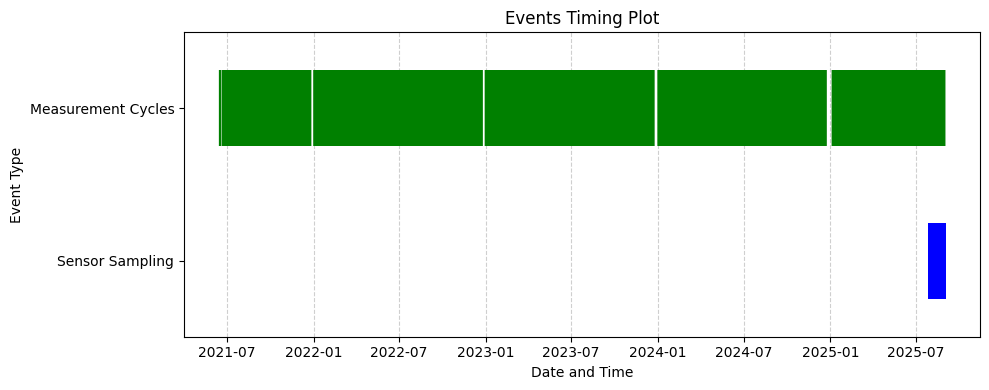

In [ ]:
# @title  3.1 Check Intersection of Label and Sensor Sampling

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Get the valid timestamps from both dataframes
# Note: Measurement Cycles are when labels are sampled (lens contamination measurement)
sensor_sampling_times = df['DateTime'].dropna()
measurement_cycle_times = label_df['DateTime'].dropna()

# Create an event plot with two sets of data
# We plot them at different 'y' levels (lineoffsets) and with different colors
plt.eventplot(
    [sensor_sampling_times, measurement_cycle_times],
    orientation='horizontal',
    colors=['blue', 'green'],
    lineoffsets=[1, 2],  # Plot first at y=1, second at y=2
    linelengths=0.5
)

# Add titles and labels
plt.title(f'{machine_name} - Events Timing Plot')
plt.xlabel('Date and Time')

# Use the y-axis to label the two event types
plt.yticks([1, 2], ['Sensor Sampling', 'Pollu. Labeling'])
plt.ylabel('Event Type') # Add y-label back

# Set Y-limits to keep the plot tidy
plt.ylim(0.5, 2.5)

# Add a grid for the x-axis
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() # Adjusts plot to prevent labels overlapping

# Display the plot
plt.show()

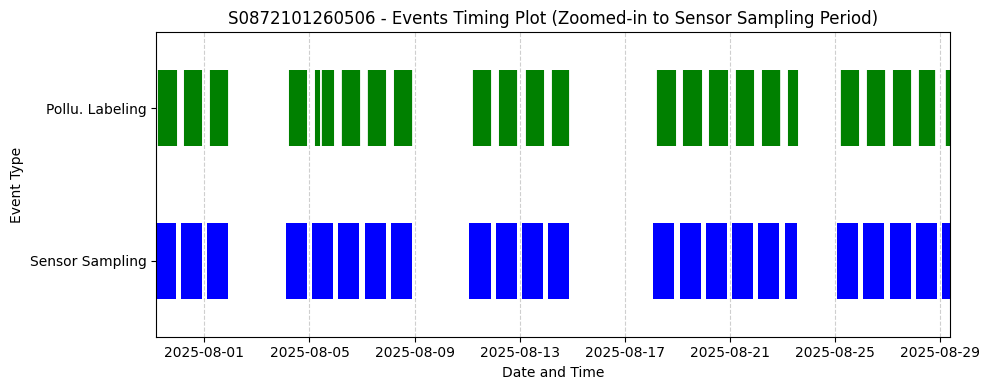

In [ ]:
# @title  3.2 Zoom-in on the Intersection of Label and Sensor Sampling
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Get the valid timestamps from both dataframes
sensor_sampling_times = df['DateTime'].dropna()
measurement_cycle_times = label_df['DateTime'].dropna()

# Get the start and end time of the sensor sampling data
sensor_start_time = sensor_sampling_times.min()
sensor_end_time = sensor_sampling_times.max()

# Create an event plot with two sets of data
# Plot them at different 'y' levels (lineoffsets) and with different colors
plt.eventplot(
    [sensor_sampling_times, measurement_cycle_times],
    orientation='horizontal',
    colors=['blue', 'green'],
    lineoffsets=[1, 2],  # Plot first at y=1, second at y=2
    linelengths=0.5
)

# Add titles and labels
plt.title(f'{machine_name} - Events Timing Plot (Zoomed-in to Sensor Sampling Period)')
plt.xlabel('Date and Time')

# Use the y-axis to label the two event types
plt.yticks([1, 2], ['Sensor Sampling', 'Pollu. Labeling'])
plt.ylabel('Event Type') # Add y-label back

# Set Y-limits to keep the plot tidy
plt.ylim(0.5, 2.5)

# Set the x-axis limits to the range of the sensor sampling data
plt.xlim(sensor_start_time, sensor_end_time)


# Add a grid for the x-axis
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() # Adjusts plot to prevent labels overlapping

# Display the plot
plt.show()

In [ ]:
# @title 3.3 Extract 14th and 15th bits from iPartOpType
# Assuming 0-based indexing for bit positions (i.e., bit 14 is 2^14)

# Using .values to perform the bitwise operation on the numpy array instead of the Series
df['iPartOpType_Bit14'] = (df['iPartOpType'].values >> 14) & 1
df['iPartOpType_Bit15'] = (df['iPartOpType'].values >> 15) & 1

print("Extraction complete. New columns added: 'iPartOpType_Bit14', 'iPartOpType_Bit15'")

# Calculate number of distinct 'ON' events for Bit 15
# We detect where the value changes from 0 to 1 (rising edge)
bit15_changes = df['iPartOpType_Bit15'].diff()
bit15_starts = (bit15_changes == 1).sum()
print(f"\nNumber of distinct 'ON' periods (rising edges) for Bit 15: {bit15_starts}")

# Filter Label Data to match the exact sensor time window for a fair comparison
start_time = df['DateTime'].min()
end_time = df['DateTime'].max()
label_df_filtered = label_df[
    (label_df['DateTime'] >= start_time) &
    (label_df['DateTime'] <= end_time)
]
print(f"\nTotal Label Rows (Within Sensor Time Window): {len(label_df_filtered)}")

Extraction complete. New columns added: 'iPartOpType_Bit14', 'iPartOpType_Bit15'

Number of distinct 'ON' periods (rising edges) for Bit 15: 685

Total Label Rows (Within Sensor Time Window): 678


In [ ]:
# @title 3.4 Visualize Downsampled(every 100th) Sensor Columns + poll_lens and poll_PW
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the Time Window based on df
start_time = df['DateTime'].min()
end_time = df['DateTime'].max()

# Filter label_df to this window
label_df_filtered = label_df[
    (label_df['DateTime'] >= start_time) &
    (label_df['DateTime'] <= end_time)
].copy()

# Define columns groups
df_columns = [
    #'Temperature lens IR (0.01 °C)',
    #'Temperature window IR (0.01 °C)',
    'Temperature window BTS (0.01 °C)',
    'Pressure (0.01 bar)',
    'Laser set power (W)',
    'iPartOpType',
    'iPartOpType_Bit14',
    'iPartOpType_Bit15',
    #'$AC_VACTW (mm/min)',
    #'Gas set pressure (0.01 bar)',
    #'Gas type',
    #'Bar material',
    #'Bar thickness'
]

label_columns = ['poll_PW', 'poll_lens']
all_titles = df_columns + label_columns

# Create subplots (Shared X-Axis)
fig = make_subplots(
    rows=len(all_titles),
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.015,
    subplot_titles=all_titles
)

# Add traces for the main DF (using the downsampled version for performance)
# Ensure df_plot is available (re-creating just in case)
df_plot = df.iloc[::100].copy()

for i, col in enumerate(df_columns):
    fig.add_trace(
        go.Scatter(x=df_plot['DateTime'], y=df_plot[col], name=col),
        row=i+1, col=1
    )

# Add traces for the Label DF
# We use 'markers+lines' here because label data might be less frequent
start_row = len(df_columns) + 1
for i, col in enumerate(label_columns):
    fig.add_trace(
        go.Scatter(
            x=label_df_filtered['DateTime'],
            y=label_df_filtered[col],
            name=col,
            mode='lines+markers',
            marker=dict(size=4)
        ),
        row=start_row + i, col=1
    )

# Layout adjustments
fig.update_layout(
    height=200 * len(all_titles),  # Dynamic height
    title_text=f"{machine_name}: Sensor Data + Label Data (Synced Time Window)",
    showlegend=False
)

# Add Range Slider to the bottom-most plot
fig.update_xaxes(rangeslider=dict(visible=True), row=len(all_titles), col=1)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title 3.4.1 Zoom into n-Minute Segment Plot (without downsampling)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
import pandas as pd

# Change this variable to inspect different windows
start_time_str = "2025-08-05 05:30:00"
num_mins = 60*17

# Parse start time and define n-minute window
try:
    plot_start_time = pd.to_datetime(start_time_str)
except:
    plot_start_time = df['DateTime'].min()
    print(f"Invalid format. Using data start time: {plot_start_time}")

plot_end_time = plot_start_time + timedelta(minutes=num_mins)

print(f"Plotting window: {plot_start_time} to {plot_end_time}")

# Filter Dataframes
df_zoom = df[(df['DateTime'] >= plot_start_time) & (df['DateTime'] <= plot_end_time)].copy()
label_zoom = label_df[(label_df['DateTime'] >= plot_start_time) & (label_df['DateTime'] <= plot_end_time)].copy()

if df_zoom.empty:
    print("No sensor data found in this time window.")
else:
    # Define columns to plot (including the new Bit columns)
    df_columns = [
    #'Temperature lens IR (0.01 °C)',
    #'Temperature window IR (0.01 °C)',
    'Temperature window BTS (0.01 °C)',
    'Pressure (0.01 bar)',
    'Laser set power (W)',
    'iPartOpType',
    'iPartOpType_Bit14',
    'iPartOpType_Bit15',
    #'$AC_VACTW (mm/min)',
    #'Gas set pressure (0.01 bar)',
    #'Gas type',
    #'Bar material',
    #'Bar thickness'
    ]

    label_columns = ['poll_PW', 'poll_lens']
    all_titles = df_columns + label_columns

    # Create subplots
    fig = make_subplots(
        rows=len(all_titles),
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.02,
        subplot_titles=all_titles
    )

    # Add traces for Sensor Data
    # No downsampling needed for 1 minute of data
    for i, col in enumerate(df_columns):
        fig.add_trace(
            go.Scatter(x=df_zoom['DateTime'], y=df_zoom[col], name=col),
            row=i+1, col=1
        )

    # Add traces for Label Data
    start_row = len(df_columns) + 1
    for i, col in enumerate(label_columns):
        fig.add_trace(
            go.Scatter(
                x=label_zoom['DateTime'],
                y=label_zoom[col],
                name=col,
                mode='lines+markers',
                marker=dict(size=8, color='red') # Larger markers to see sparse events
            ),
            row=start_row + i, col=1
        )

    # Layout
    fig.update_layout(
        height=250 * len(all_titles),
        title_text=f"{num_mins}-Minute Zoom: {plot_start_time}",
        showlegend=False
    )

    # Force x-axis range to exactly the 1-minute window
    fig.update_xaxes(range=[plot_start_time, plot_end_time], row=len(all_titles), col=1)

    fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
# @title 4. Per Day Measurements Table

# 1. Count number of days with values (maybe use the sensor data datetime column and label data datetime column, should be same)
# 2. For each day measure the
# a. number of rising edge of ipartoptype_bit15 (to know supposed number of measurement cycle)
# a. poll's sample count (just same for both poll)
# a. time difference between first ipartoptype rising edge vs first poll
# a. time difference between last ipartoptype rising edge vs lsat poll
# b. poll_PW's min, mean, max
# b. poll_lens's min, mean, max
# d. slope of a linear regression for poll lens(to know trend)
# d. slope of a linear regression for poll PW(to know trend)

import pandas as pd
import numpy as np
from scipy.stats import linregress

# Ensure DateTime columns are set
if 'DateTime' not in df.columns:
    df['DateTime'] = pd.to_datetime(df['Time (ms)'], unit='ms')

# Define the Time Window based on df
start_time = df['DateTime'].min()
end_time = df['DateTime'].max()

# Filter label_df to this window
label_df_filtered = label_df[
    (label_df['DateTime'] >= start_time) &
    (label_df['DateTime'] <= end_time)
].copy()

# Create Date columns for grouping
df['Date'] = df['DateTime'].dt.date
label_df_filtered['Date'] = label_df_filtered['DateTime'].dt.date

# --- 1. Process Sensor Data (df) ---
# Ensure Bit15 column exists (extract if missing)
if 'iPartOpType_Bit15' not in df.columns:
    df['iPartOpType_Bit15'] = (df['iPartOpType'] >> 15) & 1

# Identify Rising Edges (0 -> 1 transitions) for the machine cycle
df['is_rising_edge'] = (df['iPartOpType_Bit15'].diff() == 1)

# Aggregation functions for Sensor Data
def get_first_rising(series):
    # Returns the DateTime of the first rising edge in the group
    vals = series[df.loc[series.index, 'is_rising_edge']]
    return vals.min() if not vals.empty else pd.NaT

def get_last_rising(series):
    # Returns the DateTime of the last rising edge in the group
    vals = series[df.loc[series.index, 'is_rising_edge']]
    return vals.max() if not vals.empty else pd.NaT

# Group Sensor Data by Date
sensor_daily = df.groupby('Date').agg(
    Cycle_Count=('is_rising_edge', 'sum'),
    First_Cycle_Time=('DateTime', get_first_rising),
    Last_Cycle_Time=('DateTime', get_last_rising)
)

# --- 2. Process Label Data (label_df) ---

def calculate_slope(series, time_series):
    if len(series) < 2:
        return np.nan
    # Convert timestamps to seconds for regression
    x = time_series.map(pd.Timestamp.timestamp).values
    y = series.values
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

def get_label_stats(group):
    stats = {}
    stats['Poll_Count'] = len(group)
    stats['First_Poll_Time'] = group['DateTime'].min()
    stats['Last_Poll_Time'] = group['DateTime'].max()

    # Poll PW Stats
    stats['Poll_PW_Min'] = group['poll_PW'].min()
    stats['Poll_PW_Mean'] = group['poll_PW'].mean()
    stats['Poll_PW_Max'] = group['poll_PW'].max()
    stats['Slope_PW_d%/dt'] = calculate_slope(group['poll_PW'], group['DateTime'])

    # Poll Lens Stats
    stats['Poll_Lens_Min'] = group['poll_lens'].min()
    stats['Poll_Lens_Mean'] = group['poll_lens'].mean()
    stats['Poll_Lens_Max'] = group['poll_lens'].max()
    stats['Slope_Lens_d%/dt'] = calculate_slope(group['poll_lens'], group['DateTime'])

    return pd.Series(stats)

# Group Label Data by Date
# include_groups=False fixes the DeprecationWarning in newer pandas versions
label_daily = label_df_filtered.groupby('Date').apply(get_label_stats, include_groups=False)

# --- 3. Merge and Calculate Differences ---
# Merge on Date index
daily_stats = pd.merge(sensor_daily, label_daily, left_index=True, right_index=True, how='outer')

# Calculate Time Differences
daily_stats['1st_PollvCycle_dT'] = daily_stats['First_Poll_Time'] - daily_stats['First_Cycle_Time']
daily_stats['last_PollvCycle_dT'] = daily_stats['Last_Poll_Time'] - daily_stats['Last_Cycle_Time']

# Custom formatting function
def format_timedelta_custom(td):
    if pd.isnull(td):
        return '-'

    total_sec = td.total_seconds()
    is_neg = total_sec < 0
    total_sec = abs(total_sec)

    days = int(total_sec // 86400)
    rem = int(total_sec % 86400)
    hours = rem // 3600
    rem %= 3600
    minutes = rem // 60
    seconds = int(rem % 60)

    time_str = f"{hours:02}:{minutes:02}:{seconds:02}"
    sign_str = "-" if is_neg else ""

    # Only show days if > 0
    if days > 0:
        return f"{sign_str}{days}d {time_str}"
    else:
        return f"{sign_str}{time_str}"

# Apply formatting
daily_stats['1st_PollvCycle_dT'] = daily_stats['1st_PollvCycle_dT'].apply(format_timedelta_custom)
daily_stats['last_PollvCycle_dT'] = daily_stats['last_PollvCycle_dT'].apply(format_timedelta_custom)

# Select and Reorder columns for final table
final_columns = [
    'Cycle_Count', 'Poll_Count',
    '1st_PollvCycle_dT', 'last_PollvCycle_dT',
    'Poll_PW_Min', 'Poll_PW_Mean', 'Poll_PW_Max', 'Slope_PW_d%/dt',
    'Poll_Lens_Min', 'Poll_Lens_Mean', 'Poll_Lens_Max', 'Slope_Lens_d%/dt'
]

# Transpose the DataFrame (Date becomes columns)
display_df = daily_stats[final_columns].T

# Display result with caption
if 'machine_name' in locals():
    caption_text = f"Daily Measurements Table ({len(label_daily)} days) : {machine_name}"
else:
    caption_text = f"Daily Measurements Table ({len(label_daily)} days)"

display(display_df.style.set_caption(caption_text))

Date,2025-07-30,2025-07-31,2025-08-01,2025-08-04,2025-08-05,2025-08-06,2025-08-07,2025-08-08,2025-08-11,2025-08-12,2025-08-13,2025-08-14,2025-08-18,2025-08-19,2025-08-20,2025-08-21,2025-08-22,2025-08-23,2025-08-25,2025-08-26,2025-08-27,2025-08-28,2025-08-29
Cycle_Count,31,28,31,30,27,33,32,36,31,37,26,29,32,30,30,31,35,15,34,33,32,29,13
Poll_Count,31,28,31,30,27,33,32,35,29,36,26,28,33,30,30,31,35,15,34,33,32,29,10
1st_PollvCycle_dT,02:00:06,02:00:06,02:00:06,02:00:07,02:00:06,02:00:06,02:00:06,02:00:06,02:03:47,02:00:07,02:00:06,02:00:07,02:00:06,02:00:06,02:00:06,02:00:06,02:00:06,02:00:06,02:00:06,02:00:06,02:00:06,02:00:07,02:00:06
last_PollvCycle_dT,02:00:07,02:00:06,02:00:06,02:00:07,02:00:06,02:00:06,02:00:07,02:00:07,02:00:05,02:00:06,02:00:06,02:00:07,02:30:17,02:00:06,02:00:07,02:00:07,02:00:06,02:00:07,02:00:07,02:00:07,02:00:07,02:00:06,00:07:48
Poll_PW_Min,30,44,53,64,124,163,185,252,0,0,377,14,16,53,56,78,99,111,114,159,6,15,15
Poll_PW_Mean,50.516129,61.678571,76.580645,113.366667,158.925926,193.090909,228.218750,295.342857,337.310345,374.166667,443.192308,305.142857,55.030303,70.000000,78.833333,95.193548,124.057143,147.733333,156.529412,208.878788,236.812500,32.862069,20.700000
Poll_PW_Max,68,83,103,150,186,226,270,330,378,429,491,819,82,87,104,116,233,174,198,258,300,48,31
Slope_PW_d%/dt,0.000377,0.000290,0.000615,0.001345,0.000675,0.000831,0.000739,0.000943,0.001387,0.001030,0.001654,-0.013061,0.000740,0.000151,0.000491,0.000139,0.000384,0.001744,0.000830,0.001052,-0.001394,0.000520,0.000010
Poll_Lens_Min,3,4,5,6,12,16,18,25,31,0,38,1,1,5,5,7,10,11,11,16,0,1,1
Poll_Lens_Mean,4.677419,5.750000,7.290323,10.966667,15.481481,18.909091,22.468750,29.285714,34.620690,37.194444,44.269231,30.250000,5.060606,6.633333,7.366667,9.096774,12.085714,14.533333,15.352941,20.545455,23.468750,2.827586,1.600000


In [2]:

# @title 5. Generate Plots and Measurements for each Machines

# For each machine,
# 1. Record the checks
# Something like:
# a. Check dataframe info of sensor data (columns, null count, dtype, mem size)
# a. Checking time axis of sensor data
#    Start Time: 2025-07-30 03:53:54.772000 (1753847634772)
#      End Time: 2025-08-29 09:35:38.887000 (1756460138887)
#    Total Duration: 30 days, 5:41:44.115000
# a. Check dataframe info of label data (columns, null count, dtype, mem size)
# b. Checking time axis of label data
#    Start Time: 2021-06-16 15:54:06 (1623851646000)
#      End Time: 2025-08-29 11:20:41 (1756459241000)
#    Total Duration: 1534 days, 19:26:35
# save this into a png

# 2. generate the Event Timing Plot (the one not zoomed in, figsize 10,4, export to png)
# 3. generate the visualization (for the length of sensor col) of the downsampled sensor columns + pollution data. Specifically:
    #'$AC_VACTW (mm/min)',
    #'Gas set pressure (0.01 bar)',
    #'Gas type',
    #'Bar material',
    #'Bar thickness'
    #'Pressure (0.01 bar)',
    #'Laser set power (W)',
    #'Temperature lens IR (0.01 °C)',
    #'Temperature window IR (0.01 °C)',
    #'Temperature window BTS (0.01 °C)',
    #'iPartOpType_Bit15',
    # 'poll_PW'
    # 'poll_lens'
# do something similar to what we have done section 3.4, but just use matplotlib, then export it into png

# 4. Daily Measurements Table (like above, export it into png), maybe use dataframe-image package, and I suppose the default style will work just fine.

# For each machine, put each of the png into a pdf, one page per pdf
# Save the result in /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/1_data_exploration_results

In [ ]:
# @title 5.0 Generate Plots and Measurements for each Machines (INSTALL required library)
!pip install dataframe-image

In [3]:
# @title 5.1 Generate Plots and Measurements for each Machines
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import linregress
import gc
import warnings
import io

# Try importing dataframe_image, handle if missing
try:
    import dataframe_image as dfi
except ImportError:
    dfi = None
    print("dataframe_image module not found. Tables will be skipped or minimal.")

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Configuration ---
OUTPUT_DIR = os.path.join(CODING_PATH, '1_data_exploration_results')
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print(f"Report will be generated at: {OUTPUT_DIR}")

# --- Helper Functions ---

def parse_log_file(log_path):
    """Parses the label log file using the logic from section 2."""
    try:
        temp_df = pd.read_csv(log_path, skiprows=1, header=None, sep=';', engine='python')
        regex_pattern = r'^(.*\])\s+(.*)'
        separated_col_0 = temp_df[0].str.extract(regex_pattern, expand=True)

        label_df = pd.DataFrame()
        label_df['Timestamp'] = separated_col_0[0].str.strip('[]')
        label_df['dT_PW'] = separated_col_0[1]
        label_df['dT_lens'] = temp_df[1].astype(str).str.strip()
        label_df['poll_PW'] = temp_df[2].astype(str).str.strip()
        label_df['poll_lens'] = temp_df[3].astype(str).str.strip()

        numeric_cols = ['dT_PW', 'dT_lens', 'poll_PW', 'poll_lens']
        label_df[numeric_cols] = label_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

        ts_parts = label_df['Timestamp'].str.split(' : ', expand=True)
        label_df['DateTime'] = pd.to_datetime(ts_parts[0], format='%d/%m/%Y %H:%M:%S')

        return label_df
    except Exception as e:
        print(f"    Error parsing log: {e}")
        return pd.DataFrame()

def format_timedelta_custom(td):
    """Formats timedelta to human readable string (d HH:MM:SS)."""
    if pd.isnull(td):
        return '-'
    total_sec = td.total_seconds()
    is_neg = total_sec < 0
    total_sec = abs(total_sec)
    days = int(total_sec // 86400)
    rem = int(total_sec % 86400)
    hours = rem // 3600
    rem %= 3600
    minutes = rem // 60
    seconds = int(rem % 60)
    time_str = f"{hours:02}:{minutes:02}:{seconds:02}"
    sign_str = "-" if is_neg else ""
    if days > 0:
        return f"{sign_str}{days}d {time_str}"
    else:
        return f"{sign_str}{time_str}"

def calculate_daily_stats_table(df, label_df):
    """Generates the transposed daily stats DataFrame."""
    # Sensor Prep: Bit15 logic is handled in main loop, but strictly:
    # Rising edge detection
    df['is_rising_edge'] = (df['iPartOpType_Bit15'].diff() == 1)

    def get_first_rising(series):
        vals = series[df.loc[series.index, 'is_rising_edge']]
        return vals.min() if not vals.empty else pd.NaT
    def get_last_rising(series):
        vals = series[df.loc[series.index, 'is_rising_edge']]
        return vals.max() if not vals.empty else pd.NaT

    df['Date'] = df['DateTime'].dt.date
    sensor_daily = df.groupby('Date').agg(
        Cycle_Count=('is_rising_edge', 'sum'),
        First_Cycle_Time=('DateTime', get_first_rising),
        Last_Cycle_Time=('DateTime', get_last_rising)
    )

    # Label Prep
    label_df_filtered = label_df[
        (label_df['DateTime'] >= df['DateTime'].min()) &
        (label_df['DateTime'] <= df['DateTime'].max())
    ].copy()
    if label_df_filtered.empty:
        return pd.DataFrame()

    label_df_filtered['Date'] = label_df_filtered['DateTime'].dt.date

    def calculate_slope(series, time_series):
        if len(series) < 2: return np.nan
        # Convert datetime to seconds (float) explicitly
        # astype('int64') gives nanoseconds, divide by 1e9 to get seconds
        x = time_series.astype('int64') // 10**9
        y = series.values
        slope, _, _, _, _ = linregress(x, y)
        return slope

    def get_label_stats(group):
        stats = {}
        stats['Poll_Count'] = len(group)
        stats['First_Poll_Time'] = group['DateTime'].min()
        stats['Last_Poll_Time'] = group['DateTime'].max()
        stats['Poll_PW_Min'] = group['poll_PW'].min()
        stats['Poll_PW_Mean'] = group['poll_PW'].mean()
        stats['Poll_PW_Max'] = group['poll_PW'].max()
        stats['Slope_PW_d%/dsec'] = calculate_slope(group['poll_PW'], group['DateTime'])
        stats['Poll_Lens_Min'] = group['poll_lens'].min()
        stats['Poll_Lens_Mean'] = group['poll_lens'].mean()
        stats['Poll_Lens_Max'] = group['poll_lens'].max()
        stats['Slope_Lens_d%/dsec'] = calculate_slope(group['poll_lens'], group['DateTime'])
        return pd.Series(stats)

    label_daily = label_df_filtered.groupby('Date').apply(get_label_stats, include_groups=False)

    # Merge & Calc
    daily_stats = pd.merge(sensor_daily, label_daily, left_index=True, right_index=True, how='outer')
    daily_stats['1st_PollvCycle_dT'] = daily_stats['First_Poll_Time'] - daily_stats['First_Cycle_Time']
    daily_stats['last_PollvCycle_dT'] = daily_stats['Last_Poll_Time'] - daily_stats['Last_Cycle_Time']

    # Format
    daily_stats['1st_PollvCycle_dT'] = daily_stats['1st_PollvCycle_dT'].apply(format_timedelta_custom)
    daily_stats['last_PollvCycle_dT'] = daily_stats['last_PollvCycle_dT'].apply(format_timedelta_custom)

    cols = ['Cycle_Count', 'Poll_Count', '1st_PollvCycle_dT', 'last_PollvCycle_dT',
            'Poll_PW_Min', 'Poll_PW_Mean', 'Poll_PW_Max', 'Slope_PW_d%/dsec',
            'Poll_Lens_Min', 'Poll_Lens_Mean', 'Poll_Lens_Max', 'Slope_Lens_d%/dsec']

    return daily_stats[cols].T

# --- Main Loop ---
csv_files = sorted([f for f in os.listdir(CSV_PATH) if f.endswith('.csv')])

for idx, csv_file in enumerate(csv_files):
    machine_name = csv_file.replace('.csv', '')
#for _ in [1]:
#    idx = 0
#    csv_file = "S0872101260506.csv"
#    machine_name = "S0872101260506"
    print(f"[{idx+1}/{len(csv_files)}] Processing {machine_name}...")

    PDF_FILENAME = f'{machine_name}.pdf'
    PDF_PATH = os.path.join(OUTPUT_DIR, PDF_FILENAME)
    # Check if PDF_PATH already exists, if yes, skip
    if os.path.exists(PDF_PATH):
        print(f"    PDF already exists. Skipping.")
        continue

    with PdfPages(PDF_PATH) as pdf:
        try:
            # Load Data
            df = pd.read_csv(os.path.join(CSV_PATH, csv_file))
            df['DateTime'] = pd.to_datetime(df['Time (ms)'], unit='ms')

            # 1. Calculate Bit15 (Fix for 'Series' and 'int' error)
            if 'iPartOpType' in df.columns:
                df['iPartOpType'] = pd.to_numeric(df['iPartOpType'], errors='coerce').fillna(0).astype(int)
                df['iPartOpType_Bit15'] = (df['iPartOpType'].values >> 15) & 1
            else:
                df['iPartOpType_Bit15'] = 0

            log_path = os.path.join(LABEL_PATH, f"{machine_name}.log")
            if not os.path.exists(log_path):
                print("    No label file. Skipping.")
                continue
            label_df = parse_log_file(log_path)
            if label_df.empty:
                continue

            # --- Page 1: Checks (Portrait) ---
            fig1 = plt.figure(figsize=(8.27, 11.69))
            plt.axis('off')
            txt = f"Machine: {machine_name}\n\n"
            txt += "1. Data Checks & Inventory\n"
            txt += "--------------------------\n"
            txt += f"Sensor Data (CSV):\n"
            txt += f"  - Rows: {len(df):,}\n"
            txt += f"  - Time Start: {df['DateTime'].min()}\n"
            txt += f"  - Time End:   {df['DateTime'].max()}\n"
            txt += f"  - Duration:   {df['DateTime'].max() - df['DateTime'].min()}\n\n"
            txt += f"Label Data (Log):\n"
            txt += f"  - Rows: {len(label_df):,}\n"
            txt += f"  - Time Start: {label_df['DateTime'].min()}\n"
            txt += f"  - Time End:   {label_df['DateTime'].max()}\n"
            txt += f"  - Duration:   {label_df['DateTime'].max() - label_df['DateTime'].min()}\n"
            plt.text(0.1, 0.9, txt, transform=fig1.transFigure, fontsize=12, family='monospace', va='top')
            pdf.savefig(fig1)
            plt.close(fig1)

            # --- Page 2: Event Timing (Image, 10x4) ---
            # Generate plot off-screen, save as PNG buffer, embed image
            fig_temp, ax = plt.subplots(figsize=(10, 4))
            sensor_t = df['DateTime'].dropna()
            label_t = label_df['DateTime'].dropna()
            # Full unzoomed range
            ax.eventplot([sensor_t, label_t], colors=['blue', 'green'], lineoffsets=[1, 2], linelengths=0.5)
            ax.set_yticks([1, 2])
            ax.set_yticklabels(['Sensor', 'Label'])
            ax.set_title(f'{machine_name}: Event Timing (Full Duration)')
            ax.grid(True, axis='x', linestyle='--')

            buf = io.BytesIO()
            fig_temp.savefig(buf, format='png', dpi=150, bbox_inches='tight')
            buf.seek(0)
            plt.close(fig_temp)

            # Place image on PDF page (Portrait)
            fig2 = plt.figure(figsize=(8.27, 11.69))
            plt.axis('off')
            plt.title("2. Event Timing Plot", fontsize=14, y=0.9)
            ax_img = plt.axes([0.05, 0.55, 0.9, 0.3], frameon=False) # Center manually
            ax_img.set_axis_off()
            img = mpimg.imread(buf)
            ax_img.imshow(img, aspect='auto')
            # 'auto' aspect here fits it into the axes box defined above
            pdf.savefig(fig2)
            plt.close(fig2)

            # --- Page 3: Visualization (Matplotlib) ---
            # Define columns to plot (similar to section 3.4)
            potential_cols = [
                '$AC_VACTW (mm/min)',
                'Gas set pressure (0.01 bar)',
                'Gas type',
                'Bar material',
                'Bar thickness'
                'Pressure (0.01 bar)',
                'Laser set power (W)',
                'Temperature lens IR (0.01 °C)',
                'Temperature window IR (0.01 °C)',
                'Temperature window BTS (0.01 °C)',
                'iPartOpType_Bit15',
            ]
            plot_cols = [c for c in potential_cols if c in df.columns]
            label_plot_cols = ['poll_PW', 'poll_lens']

            total_plots = len(plot_cols) + len(label_plot_cols)
            if total_plots > 0:
                # Create subplots (shared X)
                fig3, axes = plt.subplots(total_plots, 1, figsize=(11.69, 3 * total_plots), sharex=True)
                if total_plots == 1: axes = [axes]

                # Plot Sensor Data (Downsampled)
                df_sub = df.iloc[::100] # Downsample for performance

                for i, col in enumerate(plot_cols):
                    ax = axes[i]
                    ax.plot(df_sub['DateTime'], df_sub[col], label=col, linewidth=0.8)
                    ax.set_ylabel(col[:20]+'..' if len(col)>20 else col, fontsize=8)
                    ax.legend(loc='upper right', fontsize=8)
                    ax.grid(True, linestyle=':', alpha=0.6)

                # Plot Label Data
                # Filter label data to relevant time window
                label_sub = label_df[(label_df['DateTime'] >= df['DateTime'].min()) &
                                     (label_df['DateTime'] <= df['DateTime'].max())]

                start_idx = len(plot_cols)
                for i, col in enumerate(label_plot_cols):
                    ax = axes[start_idx + i]
                    ax.plot(label_sub['DateTime'], label_sub[col], 'o-', color='red', markersize=4, linewidth=0.8, label=col)
                    ax.set_ylabel(col, fontsize=8)
                    ax.legend(loc='upper right', fontsize=8)
                    ax.grid(True, linestyle=':', alpha=0.6)

                plt.xlabel('Date Time')
                fig3.suptitle(f"{machine_name}: Sensor & Pollution Trends", fontsize=14)
                plt.tight_layout(rect=[0, 0.03, 1, 0.97])

                pdf.savefig(fig3)
                plt.close(fig3)

            # --- Page 4+: Table (Paged via dataframe_image) ---
            if dfi is not None:
                stats_df = calculate_daily_stats_table(df, label_df)
                num_days = len(stats_df.columns) # record original number of days before padding
                chunk_size = 12 # Dates per page
                # pad stats_df column so that it is a multiple of chunk_size
                if len(stats_df.columns) % chunk_size != 0:
                    stats_df = stats_df.reindex(columns=stats_df.columns.tolist() + ['----------'] * (chunk_size - len(stats_df.columns) % chunk_size))
                if not stats_df.empty:
                    cols = stats_df.columns
                    chunks = [cols[i:i+chunk_size] for i in range(0, len(cols), chunk_size)]

                    for i, chunk in enumerate(chunks):
                        # Create separate figure for the table page
                        fig_table = plt.figure(figsize=(11.69, 8.27)) # Landscape
                        plt.axis('off')

                        disp_df = stats_df[chunk]

                        # --- 1. Style the Dataframe ---
                        # Use pandas Styler for nice formatting
                        styler = disp_df.style.set_caption(f"Daily Measurements ({num_days} days): {machine_name} (Part {i+1})")

                        # CSS Styling
                        styler.set_table_styles([
                            {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('padding', '10px'), ('color', 'black')]},
                            {'selector': 'thead th', 'props': [('background-color', '#40466e'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('border', '1px solid white')]},
                            {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center'), ('padding', '4px'), ('font-size', '12px')]},
                            {'selector': 'tbody tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
                            {'selector': 'tbody tr:hover', 'props': [('background-color', '#ddd')]}
                        ])

                        # Format specific values if needed (e.g. NaNs)
                        styler.format(na_rep='-')

                        # --- 2. Export to Image Buffer ---
                        buf = io.BytesIO()
                        try:
                            # dfi.export renders the styler to a png
                            dfi.export(styler, buf)
                        except Exception as e:
                            print(f"    dataframe_image export failed (trying fallback): {e}")
                            try:
                                dfi.export(styler, buf, table_conversion='matplotlib') # Fallback
                            except Exception as e2:
                                print(f"    All export methods failed: {e2}")
                                continue

                        buf.seek(0)

                        # --- 3. Embed in Matplotlib Figure ---
                        img = mpimg.imread(buf)
                        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust margins
                        plt.imshow(img)
                        # Centering is handled by imshow's placement, aspect='auto' fits it to the axes

                        pdf.savefig(fig_table)
                        plt.close(fig_table)
                else:
                    # Empty placeholder page
                    fig_table = plt.figure(figsize=(11.69, 8.27))
                    plt.axis('off')
                    plt.text(0.5, 0.5, "No overlapping data found for table.", ha='center')
                    pdf.savefig(fig_table)
                    plt.close(fig_table)

            # Cleanup
            del df, label_df
            if 'stats_df' in locals(): del stats_df
            gc.collect()


        except Exception as e:
            print(f"    Error processing {machine_name}: {e}")

print(f"\nAll machines processed. Report saved to {PDF_PATH}")

dataframe_image module not found. Tables will be skipped or minimal.
Report will be generated at: /content/gdrive/MyDrive/Team 1 - Adige BLM/coding/1_data_exploration_results
[1/36] Processing LT6A2400430...
    PDF already exists. Skipping.
[2/36] Processing LT6A2400435...
    PDF already exists. Skipping.
[3/36] Processing LT7A2200719...
    PDF already exists. Skipping.
[4/36] Processing LT7A2200722...
    PDF already exists. Skipping.
[5/36] Processing LT7A2200827...
    PDF already exists. Skipping.
[6/36] Processing LT7A2200839...
    PDF already exists. Skipping.
[7/36] Processing LT7A2300098...
    Error processing LT7A2300098: Python int too large to convert to C long
[8/36] Processing LT7A2300255...
    Error processing LT7A2300255: Python int too large to convert to C long
[9/36] Processing LT7A2300516...
    PDF already exists. Skipping.
[10/36] Processing LT7A2300534...
    PDF already exists. Skipping.
[11/36] Processing LT7A2300786...
    PDF already exists. Skipping.
[1

# Everything below is scratch work

In [1]:
!pip install kaleido
!pip install --upgrade plotly
import kaleido #required
#kaleido.__version__ #0.2.1

import plotly
#plotly.__version__ #5.5.0

#now this works:
import plotly.graph_objects as go

fig = go.Figure()
fig.write_image('aaa.png')

RuntimeError: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



Note: Each vertical line signifies measurement event.



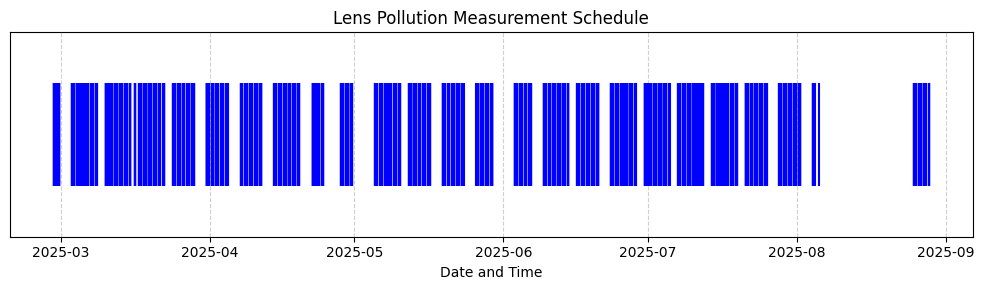

In [ ]:
import matplotlib.pyplot as plt # Import the plotting library

print("Note: Each vertical line signifies MEASUREMENT CYCLE event.")
print()

# Create Event Plot to See Schedule of Measurement Cycles
plt.figure(figsize=(10, 3)) # A shorter, wider figure

# Create an event plot. This will draw a vertical line for each timestamp.
# Plot them all at a 'y' level of 1
valid_times = label_df['DateTime'].dropna() # Filter out any potential NaT/NaN datetimes
plt.eventplot(valid_times, orientation='horizontal',
              colors='blue', lineoffsets=1, linelengths=0.5)

# Add titles and labels
plt.title('Lens Pollution Measurement Schedule')
plt.xlabel('Date and Time')

# Hide the y-axis as it's not meaningful for this plot
plt.yticks([])
plt.ylabel('') # Remove y-label

# Set Y-limits to keep the plot tidy
plt.ylim(0.5, 1.5)

# Add a grid for the x-axis
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout() # Adjusts plot to prevent labels overlapping

# Display the plot
plt.show()


In [ ]:
#Identify duration of GAPS between entries
time_diff = label_df['GMT_Epoch_ms'].diff().dropna()
sorted_vals = np.sort(time_diff.values)
clusters = [] # will be list of lists
current_cluster = [sorted_vals[0]] # consider first element as cluster 1

for v in sorted_vals[1:]: # check each time difference value
    if abs(v - current_cluster[-1]) <= 1000: # check if time_diff value v is within
                                          # 1000ms of the last cluster element
        current_cluster.append(v) # if yes, add it to the cluster
    else:
        clusters.append(current_cluster) # if no, that's the end of this cluster
        current_cluster = [v] # the latest value is the beginning of new cluster
clusters.append(current_cluster) # append the last cluster

print("Number of Instances of Each Gap Duration")
for cluster in clusters:
    # print as timedelta in human readable format
    td = timedelta(milliseconds = np.mean(cluster))
    print(f"  {td} → {len(cluster)} gap")
print()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

time_diff = df['Time (ms)'].diff().dropna()
count, division = np.histogram(time_diff)
print(count)
print()
print(division)
#plt.hist(time_diff[0], bins=1)
#plt.title("Sampling interval distribution (ms)")
#plt.show()


[7099077       1       0       0       0       0       0       0       0
       1]

[2.60000000e-01 3.41098273e+06 6.82196520e+06 1.02329477e+07
 1.36439301e+07 1.70549126e+07 2.04658951e+07 2.38768775e+07
 2.72878600e+07 3.06988425e+07 3.41098249e+07]


In [ ]:
import pandas as pd
import os


# Get a list of all CSV files in the directory
csv_files = [f for f in os.listdir(CSV_PATH) if f.endswith('.csv')]

print(f"Found {len(csv_files)} CSV files in {CSV_PATH}. Printing the first two rows of each:")

# Iterate through each CSV file
for csv_file in csv_files:
    file_path = os.path.join(CSV_PATH, csv_file)
    try:
        # Read only the first two rows
        df_head = pd.read_csv(file_path, nrows=2)
        print(f"\n--- Head of {csv_file} ---")
        display(df_head)
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")

Found 4 CSV files in /content/gdrive/MyDrive/Team 1 - Adige BLM/database_CSV. Printing the first two rows of each:

--- Head of LT6A2400430.csv ---


,Time (ms),Temperature lens IR (0.01 °C),Temperature window IR (0.01 °C),Temperature window BTS (0.01 °C),Pressure (0.01 bar),iPartOpType,$AC_VACTW (mm/min),Laser set power (W),Gas set pressure (0.01 bar),Gas type,Mach code,Bar material,Bar thickness
0,1753683466246,0,0,0,0,16384,0,0,0,0,0,0,0
1,1753683466291,2961,2809,0,0,16384,0,0,0,0,0,0,0



--- Head of LT6A2400435.csv ---


,Time (ms),Temperature lens IR (0.01 °C),Temperature window IR (0.01 °C),Temperature window BTS (0.01 °C),Pressure (0.01 bar),iPartOpType,$AC_VACTW (mm/min),Laser set power (W),Gas set pressure (0.01 bar),Gas type,Bar material,Bar thickness
0,1753682202205,2989,2378,0,0,16384,0,0,0,0,0,22
1,1753682202250,2989,2378,0,0,16384,0,0,0,0,0,22



--- Head of LT7A2200719.csv ---


,Time (ms),Temperature lens IR (0.01 °C),Temperature window IR (0.01 °C),Temperature window BTS (0.01 °C),Pressure (0.01 bar),iPartOpType,$AC_VACTW (mm/min),Laser set power (W),Gas set pressure (0.01 bar),Gas type,Mach code,Bar material,Bar thickness
0,1753685817820,2539,2228,0,0,16384,0,0,0,0,0,0,0
1,1753685817864,2539,2228,0,0,16384,0,0,0,0,0,0,0



--- Head of LT7A2200722.csv ---


,Time (ms),Temperature lens IR (0.01 °C),Temperature window IR (0.01 °C),Temperature window BTS (0.01 °C),Pressure (0.01 bar),iPartOpType,$AC_VACTW (mm/min),Laser set power (W),Gas set pressure (0.01 bar),Gas type,Mach code,Bar material,Bar thickness
0,1753165035844,2942,2739,0,0,16384,0,0,0,0,0,0,0
1,1753165035889,2942,2739,0,0,16384,0,0,0,0,0,0,0


In [ ]:
import os
os.listdir()

['.config', 'sample_data']

In [ ]:

# extract timestamp column form label_df

# separate ipartoptype and time axis of df into operation_df

# check label_df's timestamp column and see if it coincides with the
# time periods in operation_df where ipartoptype's 15th bit is 1

# which periods of machine recording has contamination value?

In [25]:
import importlib.util
import subprocess
import sys

package_name = 'kaleido'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(f"{package_name} not found. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", package_name])
else:
    print(f"{package_name} is already installed.")

kaleido is already installed.
